# Haplotype analysis *CYP6* cluster

## Input

Input files:

In [1]:
# output
outdir   = "results_sweep" # where to store output
outali   = "results_sweep" # where to store haplotype alignments
popc     = "population"

# gene of interest
chrom     = "2R"
l_nom     = "cyp6"     # nom loci
loc_start = 28480576   # start CYP6 cluster
loc_end   = 28505816   # end CYP6 cluster
loc_focus = 28480576   # polarizing mutation: start CYP6AA1
loc_p4    = 28497967

# retain all variants between these coordinates
ret_start  = 0  
ret_end    = 100e6 # all variants

# min frq to retain minor allele
minfrq     = 0.05
# input data phase1
oc_metasam_fn = "/home/xavi/dades/Variation/phase1.AR3/samples/samples.meta.txt"
oc_hapcall_fn = "/home/xavi/dades/Variation/phase1.AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.2R.h5" 
oc_effcall_fn = "/home/xavi/dades/Variation/phase1.AR3/variation/zarr/ag1000g.phase1.ar3.pass/2R/" 
oc_accessi_fn = "/home/xavi/dades/Variation/phase1.AR3/accessibility/accessibility.h5"    
oc_popc       = popc
#oc_popl       = ["BFS","CMS","GAS","GNS","CMS","UGS","AOM","BFM","GWA","KES"]
oc_popl       = ["UGS"]

# extra mutations (zanzibar, duplications, etc)
kary_fn    = "data/p1_UGS_extramutations_CYP6.csv"
# gff
gffann_fn  = "data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.9.gff3"

In [2]:
import numpy as np
import zarr
import pandas as pd
import allel
import h5py
import warnings
import scipy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import seaborn as sns
import itertools
from mlxtend.evaluate import permutation_test
warnings.simplefilter('ignore')
import random

%run scripts_helper/hapclust.py

# load plot settings
sns.set(context="notebook",style="ticks",
        font_scale=1,font="Arial",palette="bright")

## Load data

### Phase1 variants

Population and sample data:

In [3]:
# load samples list with sample code, groupings, locations etc.
oc_samples_df   = pd.read_csv(oc_metasam_fn, sep='\t')
oc_samples_bool = (oc_samples_df[oc_popc].isin(oc_popl).values)
oc_samples      = oc_samples_df[oc_samples_bool]
oc_samples.reset_index(drop=True, inplace=True)

# indexed dictionary of populations
oc_popdict = dict()
for popi in oc_popl: 
    oc_popdict[popi]  = oc_samples[oc_samples[oc_popc] == popi].index.tolist()

# add an extra population composed of all other locations
oc_popdict["all"] = []
for popi in oc_popl:
    oc_popdict["all"] = oc_popdict["all"] + oc_popdict[popi]


# report
print("Data:")
print("* Samples     = ", oc_samples.shape[0])
print("* Populations = ", set(oc_samples[oc_popc]))
print(oc_samples.groupby(("population")).size())

Data:
* Samples     =  103
* Populations =  {'UGS'}
population
UGS    103
dtype: int64


Phased variants and genotypes:

In [4]:
# declare objects with variant data
#oc_hapcall   = zarr.open(oc_hapcall_fn)
oc_hapcall   = h5py.File(oc_hapcall_fn)
# variants of genotypes
print("Variants phased...")
oc_hapcall_var = oc_hapcall[chrom]["variants"]
oc_hapvars = allel.VariantChunkedTable(oc_hapcall_var,names=["POS","REF","ALT"],index="POS") 
print(oc_hapvars.shape)
# genotype data
print("Genotypes phased...")
oc_hapcall_hap = oc_hapcall[chrom]["calldata"]["genotype"]
oc_haploty     = allel.GenotypeChunkedArray(oc_hapcall_hap) 
oc_haploty     = oc_haploty.subset(sel1=oc_samples_bool)
print(oc_haploty.shape)

Variants phased...
(11332701,)
Genotypes phased...
(11332701, 103, 2)


Get haplotypes from phased variants:

In [5]:
# recast haplotypes: drop ploidy
print("Expand phase haplotypes...")
oc_haploty_hap = oc_haploty.to_haplotypes()
print(oc_haploty_hap.shape)

Expand phase haplotypes...
(11332701, 206)


### Sample data

Get dataframe from metadata file, with sample codes, species and populations:

In [6]:
oc_samples = pd.DataFrame(data={
    "ox_code"    :  oc_samples["ox_code"].values.tolist() ,
    "species"    :  oc_samples["m_s"].values.astype(str).tolist(),
    "population" :  oc_samples[oc_popc].values.tolist() ,
})
print(oc_samples.shape)

# rename species...
oc_samples["species"].values[oc_samples["species"].values == "M"]   = "col"
oc_samples["species"].values[oc_samples["species"].values == "S"]   = "gam"
oc_samples["species"].values[oc_samples["species"].values == "M/S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "M-S"] = "gamcol"
oc_samples["species"].values[oc_samples["species"].values == "nan"] = "gamcol"

# obtain population & species list
oc_popl = np.unique(oc_samples["population"].values)
oc_spsl = np.unique(oc_samples["species"].values)

(103, 3)


Duplicate rows in metadata dataframe, to get population metadata from each haplotype:

In [7]:
oc_sampleh = pd.DataFrame(data={
    "ox_code"    :  list(itertools.chain(*[[ s + 'a', s + 'b'] for s in oc_samples["ox_code"].values.tolist()])),    # takes col from oc_samples and duplicates it, a/b
    "species"    :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["species"].values.tolist()])),
    "population" :  list(itertools.chain(*[[ s      , s      ] for s in oc_samples["population"].values.tolist()]))
})
print(oc_sampleh.shape)

(206, 3)


In [8]:
print("Population dict...")
oc_popdict = dict()
oc_popdict["UGS"] = oc_samples[oc_samples["population"] == popi].index.tolist()

print("Population dict phased...")
oc_popdich = dict()
oc_popdich["UGS"] = oc_sampleh[oc_sampleh["population"] == popi].index.tolist()

Population dict...
Population dict phased...


### Allele counts

Using both dictionaries:

In [9]:
print("Genotypes phased to allele counts (population)...")
oc_hapalco_pop = oc_haploty.count_alleles_subpops(subpops=oc_popdict)
print(oc_hapalco_pop.shape)

print("Haplotypes phased to allele counts (population)...")
oc_hapalco_hap_pop = oc_haploty_hap.count_alleles_subpops(subpops=oc_popdich)
print(oc_hapalco_hap_pop.shape)

Genotypes phased to allele counts (population)...
(11332701,)
Haplotypes phased to allele counts (population)...
(11332701,)


### Filters

#### Retain segregating and non-singletons

Define which phased variants to retain from phase1:

In [10]:
# subset data: segregating alleles & no singletons
print("Filters phased...")
oc_is_seg_h    = oc_hapalco_hap_pop["UGS"].is_segregating()[:] # segregating
oc_is_nosing_h = oc_hapalco_hap_pop["UGS"][:,:2].min(axis=1)>1 # no singletons

# subset phase2 to segregating & no singletons
oc_hapvars_seg         = oc_hapvars.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_seg         = oc_haploty.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_pop_seg     = oc_hapalco_pop.compress((oc_is_seg_h & oc_is_nosing_h))
oc_haploty_hap_seg     = oc_haploty_hap.compress((oc_is_seg_h & oc_is_nosing_h))
oc_hapalco_hap_pop_seg = oc_hapalco_hap_pop.compress((oc_is_seg_h & oc_is_nosing_h))

# report
print(oc_haploty_seg.shape,"/", oc_haploty.shape)

Filters phased...
(2738740, 103, 2) / (11332701, 103, 2)


### Other data

Accessibility:

In [11]:
# Accessibility
print("Load accessibility array...")
accessi_df  = h5py.File(oc_accessi_fn,mode="r")
accessi_arr = accessi_df[chrom]["is_accessible"][:]

Load accessibility array...


Gene annotations GFF:

In [12]:
# import gff
def geneset_gff(geneset):
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pd.DataFrame.from_items(items)
%run scripts_helper/plot_transcripts.py

geneset = allel.FeatureTable.from_gff3(gffann_fn,attributes=['ID', 'Parent'])
geneset = geneset_gff(geneset)


In [13]:
geneset[geneset["Parent"] == "AGAP002867"]

,seqid,source,type,start,end,score,strand,phase,ID,Parent
69657,2R,VectorBase,mRNA,28497087,28498674,-1.0,-,-1,AGAP002867-RA,AGAP002867


## Define haplotype clusters

Define haplotypes from Hamming distances of genotypes within a given region.

Region of interest is defined as 1000 non-singleton segregating variants located +/- a `loc_focus` position, which is the start of the *Cyp6aa1* gene.

First, a function to find clusters of haplotypes from a genetic distance matrix (Nicholas Harding, selective sweep paper?):

In [14]:
from scipy import cluster

# This function is taken from Nick's selection package
def find_clusters(dist, n, threshold=0.001, method='complete'):
    # build hierarchy
    clust = cluster.hierarchy.linkage(dist, method=method)
    # find clusters
    f = cluster.hierarchy.fcluster(clust, threshold, criterion='distance')
    # compute cluster sizes
    fsz = np.bincount(f)
    # sort largest first
    fsort = np.argsort(fsz)[::-1]
    # take largest n
    fsort = fsort[:n]
    # get haplotype indices for each cluster
    clusters = [set(np.nonzero(f == i)[0]) for i in fsort]
    return clusters

Region of interest around focal variant:

In [15]:
# Find the index of the last SNP at or just before the focal point
focus_preloc = max(np.where(oc_hapvars_seg["POS"] <= loc_focus)[0])

# Define the starting window size (in SNPs)
starting_win_size = 1000
focal_start_index = focus_preloc - int(starting_win_size/2)
focal_end_index = focus_preloc + int(starting_win_size/2)

# genotypes from haplotypes in this region:
focal_hap_matrix = oc_haploty_hap_seg[:][range(focal_start_index, focal_end_index)]

Genetic distance between haplotypes:

In [16]:
# pairwise distances
dist = allel.pairwise_distance(focal_hap_matrix, metric = 'hamming', )

# number of accessible bases in the region (required for Dxy)
is_accessible = accessi_arr[ oc_hapvars["POS"][focal_start_index] : oc_hapvars["POS"][focal_end_index] ]
n_bases = np.count_nonzero(is_accessible)

# conversion: distance to Dxy
dist_dxy = dist * focal_hap_matrix.n_variants / n_bases

# find clusters using Nick's function, at a given threshold of genetic similarity:
focal_clusters = find_clusters(dist_dxy, n=3, threshold=0.0001)

# which haps are in this cluster?
largest_focal_cluster = focal_clusters[0]
len(largest_focal_cluster)

111

Create a dataframe with cluster assignments:

In [17]:
oc_sampleh["cluster_id"] = str(-1) # by default, -1 means no cluster

for i,cluster in enumerate(focal_clusters):
    oc_sampleh["cluster_id"][cluster] = str(i)
    
oc_sampleh.head()

,ox_code,species,population,cluster_id
0,AC0090-Ca,gam,UGS,0
1,AC0090-Cb,gam,UGS,0
2,AC0091-Ca,gam,UGS,0
3,AC0091-Cb,gam,UGS,0
4,AC0092-Ca,gam,UGS,0


Save haplotype cluster assignments:

In [18]:
oc_sampleh.to_csv("%s/haplotype_clusters.csv" % (outdir),sep="\t",index=False)

## Selection signals in clusters

We want to see if the resistance haplotypes defined above have positive selection. 

In selection signal analyses, we cluster haplotypes in the following groups (derived from the networks above):

* `sweep`: cluster of n=111 haplotypes that belong to the selective sweep
* `wt`: all other haplotypes, non-clustered

Create dictionary:

In [19]:
popdich_clu = dict()

# clusters, and non clustered
popdich_clu["sweep"] = np.where(oc_sampleh["cluster_id"] == str(0))[0]
popdich_clu["wt"] = np.where(oc_sampleh["cluster_id"] != str(0))[0]

# allele counts in these clusters:
oc_hapalco_hap_clu_seg = oc_haploty_hap_seg.count_alleles_subpops(subpops=popdich_clu)
oc_hapalco_hap_clu_seg.shape

(2738740,)

Colors for plot:

In [20]:
# list colors for each haplotype in popdich_clu.keys()
colors = ["red","turquoise"]

### EHH decay

Now calculate **EHH decay** on the region of interest, using phased variants around various variants.

Common parameters for EHH plots:

In [21]:
ehh_above_thr = 0.50
ehh_below_thr = 0.05
flank_bp_EHH  = 2e5

Central variant for the EHH plot. First, the I236M mutation:

In [22]:
loc_vari = loc_p4   # polarizing mutation: I236M CYP6P4

EHH sweep
EHH wt


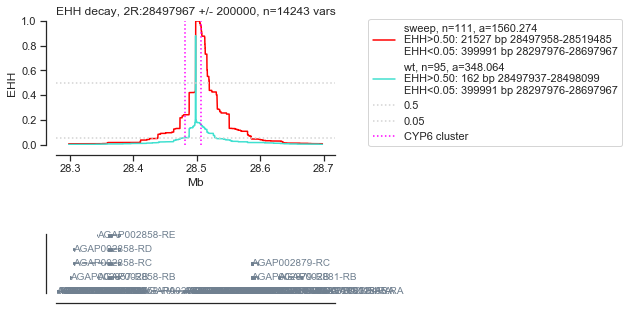

In [23]:
# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= loc_vari-flank_bp_EHH, oc_hapvars_seg["POS"] < loc_vari)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > loc_vari, oc_hapvars_seg["POS"] <= loc_vari+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/sel_EHHdecay_I236M.pdf" % (outdir))
fig = plt.figure(figsize=(5,5))
ax3 = plt.subplot(2, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    print("EHH %s" % clu_key)

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
    
    # calculate actual EHH
    clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
    clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
    clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
    clu_ehh_i_ar = np.trapz(clu_ehh_i)
    ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
    ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
    ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
    ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]

    # lab is data
    clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
        clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
        ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
        ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
    )
    
    # plot EHH background & foreground
    ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,loc_vari,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plot transcripts
ax4 = plt.subplot(4, 1, 4)
sns.despine(ax=ax4,offset=10)
ax4.axes.get_xaxis().set_ticks([])
ax4.axes.get_xlabel() == ""
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=clu_ehh_pos[0],stop=clu_ehh_pos[-1],
    height=0.2,label_transcripts=True,ax=ax4,label_axis=False,
    color="slategray")

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Same, but focusing on the duplication breakpoints rather than the 236M variant:

In [24]:
dup_start = 28480189
dup_end = 28483475

EHH sweep
EHH wt


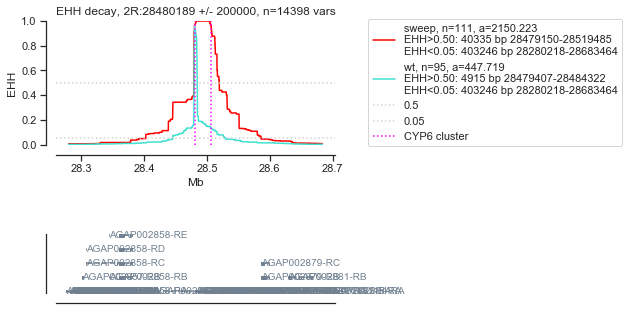

In [25]:
ehh_above_thr = 0.50
ehh_below_thr = 0.05
flank_bp_EHH  = 2e5

# variants to retain
clu_varbool_up = np.logical_and(oc_hapvars_seg["POS"] >= dup_start-flank_bp_EHH, oc_hapvars_seg["POS"] < dup_start)
clu_varbool_do = np.logical_and(oc_hapvars_seg["POS"] > dup_end, oc_hapvars_seg["POS"] <= dup_end+flank_bp_EHH)
clu_varbool    = np.logical_or(clu_varbool_up,clu_varbool_do)

# samples to remove from analysis (EHH function can't handle missing -1 data)
rmv_miss_ix   = np.unique(np.where(oc_haploty_hap_seg.subset(sel0=clu_varbool) == -1)[1]).tolist()
rmv_miss_bool = np.invert(np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=rmv_miss_ix))

# positions
clu_ehh_pos = oc_hapvars_seg["POS"].subset(sel0=clu_varbool)

# plot
pdf = PdfPages("%s/sel_EHHdecay_dup.pdf" % (outdir))
fig = plt.figure(figsize=(5,5))
ax3 = plt.subplot(2, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    print("EHH %s" % clu_key)

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)
    
    # calculate actual EHH
    clu_ehh_up_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_up,sel1=clu_sambool))
    clu_ehh_do_i = allel.ehh_decay(h=oc_haploty_hap_seg.subset(sel0=clu_varbool_do,sel1=clu_sambool))
    clu_ehh_i    = np.concatenate((clu_ehh_up_i[::-1],clu_ehh_do_i))
    clu_ehh_i_ar = np.trapz(clu_ehh_i)
    ehh_above_start = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[0]
    ehh_above_end   = clu_ehh_pos.compress(clu_ehh_i > ehh_above_thr)[-1]
    ehh_below_start = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[0]
    ehh_below_end   = clu_ehh_pos.compress(clu_ehh_i < ehh_below_thr)[-1]

    # lab is data
    clu_lab    = "%s, n=%i, a=%.3f\nEHH>%.2f: %i bp %i-%i\nEHH<%.2f: %i bp %i-%i" % (
        clu_key, len(popdich_clu[clu_key]),clu_ehh_i_ar, 
        ehh_above_thr, ehh_above_end-ehh_above_start, ehh_above_start, ehh_above_end,
        ehh_below_thr, ehh_below_end-ehh_below_start, ehh_below_start, ehh_below_end
    )
    
    # plot EHH background & foreground
    ax3.plot(clu_ehh_pos/1e6,clu_ehh_i,color=colors[i],label=clu_lab,mfc='none')

sns.despine(ax=ax3,offset=10)
ax3.set_title("EHH decay, %s:%i +/- %i, n=%s vars" % (chrom,dup_start,flank_bp_EHH,clu_ehh_pos.shape[0]))
ax3.set_xlabel("Mb")
ax3.set_ylabel("EHH")
ax3.set_ylim(0,1)
plt.axhline(ehh_above_thr, color='lightgray',linestyle=":",label=str(ehh_above_thr))
plt.axhline(ehh_below_thr, color='lightgray',linestyle=":",label=str(ehh_below_thr))
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# plot transcripts
ax4 = plt.subplot(4, 1, 4)
sns.despine(ax=ax4,offset=10)
ax4.axes.get_xaxis().set_ticks([])
ax4.axes.get_xlabel() == ""
locus_genel = plot_transcripts(
    geneset=geneset,chrom=chrom,
    start=clu_ehh_pos[0],stop=clu_ehh_pos[-1],
    height=0.2,label_transcripts=True,ax=ax4,label_axis=False,
    color="slategray")

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

### Garud H and haplotype diversity

Compute **Garud H statistics and haplotype diversity** for each cluster and estimates in the region of interest (Cyp6 cluster). Plots represent a wide region around the Cyp6 cluster, and statistics are estimated from variants within the cluster only.

In [26]:
# region to plot
flanking_bp = 2e6
clu_varbool = np.logical_and(
    oc_hapvars_seg["POS"] >= loc_vari-flanking_bp,
    oc_hapvars_seg["POS"] <= loc_vari+flanking_bp)

# region to focus: statistics will be calcualted in this region
clu_varbool_focus = np.logical_and(oc_hapvars_seg["POS"] > loc_start, oc_hapvars_seg["POS"] <= loc_end)

First, for H12 plot:

sweep
H12 = 1.000000 +/- 0.000000 SE, n = 111
wt
H12 = 0.311616 +/- 0.008887 SE, n = 95


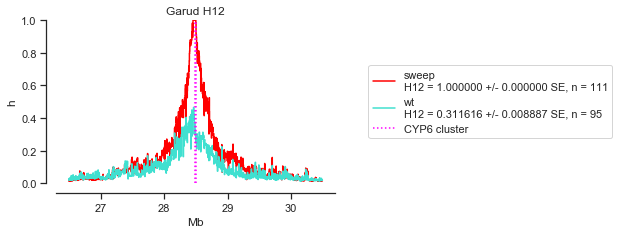

In [27]:
# open PDF
pdf = PdfPages("%s/sel_GarudH12.pdf" % (outdir))
fig = plt.figure(figsize=(5,3))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # Garud H along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=100)
    clu_gah_wib = allel.moving_garud_h(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=100)
    
    # garud in focus region
    gah_focus_est = allel.moving_garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=100)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[1], statistic=np.nanmean)
    clu_label = "%s\nH12 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_gah_wib[1], color=colors[i], label=clu_label)
    

sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H12")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Now, same with H2/H1 plot:

sweep
H2H1 = 0.000014 +/- 0.000014 SE, n = 111
wt
H2H1 = 0.214279 +/- 0.012073 SE, n = 95


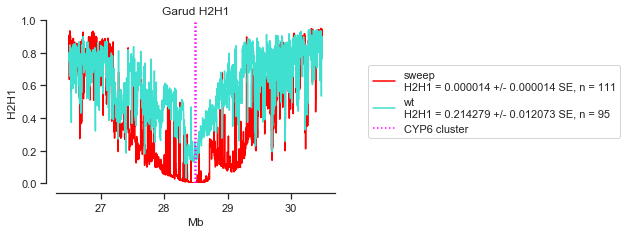

In [28]:
# open PDF
pdf = PdfPages("%s/sel_GarudH2H1.pdf" % (outdir))
fig = plt.figure(figsize=(5,3))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # Garud H along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=100)
    clu_gah_wib = allel.moving_garud_h(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=100)
    
    # garud in focus region
    gah_focus_est = allel.moving_garud_h(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=100)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est[3], statistic=np.nanmean)
    clu_label = "%s\nH2H1 = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_gah_wib[3], color=colors[i], label=clu_label)
    

sns.despine(ax=ax9,offset=10)
ax9.set_title("Garud H2H1")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("H2H1")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

Finally, haplotype diversity:

sweep
h = 0.003003 +/- 0.003003 SE, n = 111
wt
h = 0.818850 +/- 0.003888 SE, n = 95


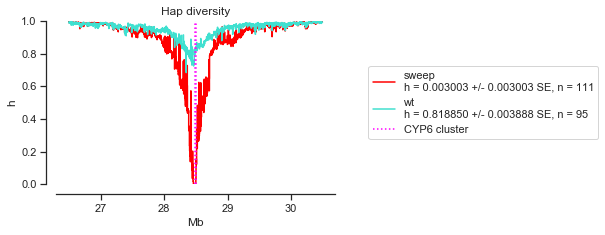

In [29]:
# open PDF
pdf = PdfPages("%s/sel_hapdiv.pdf" % (outdir))
fig = plt.figure(figsize=(5,3))
ax9 = plt.subplot(1, 1, 1)

for i,clu_key in enumerate(popdich_clu.keys()):

    # which variants include in the cluster-wise analysis of selection?
    clu_sambool = np.isin(range(0,oc_haploty_hap_seg.n_haplotypes),test_elements=popdich_clu[clu_key])
    clu_sambool = np.logical_and(clu_sambool,rmv_miss_bool)

    # hap div along chromosome
    clu_pos_wib = allel.moving_statistic(
        oc_hapvars_seg["POS"].subset(sel0=clu_varbool), statistic=lambda v: v[0], size=100)
    clu_hdi_wib = allel.moving_haplotype_diversity(
        oc_haploty_hap_seg.subset(sel0=clu_varbool,sel1=clu_sambool), size=100)
    
    # garud in focus region
    gah_focus_est = allel.moving_haplotype_diversity(oc_haploty_hap_seg.subset(sel0=clu_varbool_focus, sel1=clu_sambool), size=100)
    gah_focus_est_jack = allel.stats.misc.jackknife(gah_focus_est, statistic=np.nanmean)
    clu_label = "%s\nh = %.6f +/- %.6f SE, n = %i" % (clu_key, gah_focus_est_jack[0], gah_focus_est_jack[1],np.sum(clu_sambool))
    print(clu_label)

    # plot
    plt.subplot(1, 1, 1)
    plt.step(clu_pos_wib/1e6, clu_hdi_wib, color=colors[i], label=clu_label)
    
sns.despine(ax=ax9,offset=10)
ax9.set_title("Hap diversity")
ax9.set_ylim(0,1)
ax9.set_xlabel("Mb")
ax9.set_ylabel("h")
plt.axvline(loc_start/1e6, color='magenta',linestyle=":",label="CYP6 cluster")
plt.axvline(loc_end/1e6, color='magenta',linestyle=":",label="")
ax9.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

# save
pdf.savefig(fig,bbox_inches='tight')
pdf.close()

## Can we phase additional mutations?

If we find variants that are in high linkage disequilibrium with specimens that are 0 or 2 for the P4 mutation, we can use them to infer whether a particular haplotype has ZZB, dups, or indels.

First, load info of extra mutations:

In [30]:
kary_df = pd.read_csv(kary_fn, sep='\t')
print("extra mutations:",kary_df.shape)

extra mutations: (103, 4)


In [31]:
oc_haploty_seg_loci_extramut = np.vstack(
    (np.transpose(kary_df)[1:4],
     oc_haploty_seg.compress(clu_varbool_focus).to_n_alt(fill=-1)[:])
)

print(oc_haploty_seg_loci_extramut.shape)

# calculate their LD
# linkage disequilibrium Rogers and Huff
print("LD Rogers & Huff...")
ld_rhr_extramut = allel.rogers_huff_r(oc_haploty_seg_loci_extramut)
ld_rhr_extramut = squareform(ld_rhr_extramut)
np.fill_diagonal(ld_rhr_extramut,np.nan)

(624, 103)
LD Rogers & Huff...


Are any of them in high linkage disequilibrium with the extra mutations?

In [32]:
ld_threshold = 0.95 ## I choose this threshold so as to obtain just one variant.
is_ld_zzb    = ld_rhr_extramut[0] >= ld_threshold
is_ld_dup    = ld_rhr_extramut[1] >= ld_threshold
is_ld_indel  = ld_rhr_extramut[2] >= ld_threshold

# how many?
print("zzb",np.sum(is_ld_zzb))
print("dup",np.sum(is_ld_dup))
print("indel",np.sum(is_ld_indel))

zzb 4
dup 0
indel 4


Which ones? For ZZB:

In [33]:
print(oc_hapvars_seg["POS"][:][clu_varbool_focus][is_ld_zzb[3:]])
print(ld_rhr_extramut[2][is_ld_zzb][1:])

[28491424 28497958 28497967]
[0.9749238  0.95399505 0.95399505]


For the indel:

In [34]:
print(oc_hapvars_seg["POS"][:][clu_varbool_focus][is_ld_indel[3:]])
print(ld_rhr_extramut[2][is_ld_indel][1:])

[28491424 28497958 28497967]
[0.9749238  0.95399505 0.95399505]


So we conclude that we can use `2R:28491424` as the tagging variant for the ZZB insertion and for the small deletion, because it has the highest LD (`r = 0.9749238`). But there are no variants linked to the duplication). 

Where is it?

In [35]:
is_tagvar   = oc_hapvars_seg["POS"] == 28491424
loc_gty_tag = oc_haploty_hap_seg.subset(sel0=is_tagvar)
np.unique(is_tagvar, return_counts=True)

(array([False,  True]), array([2738739,       1]))

### Export FASTA

We create a haplotype-level table with key genotypes, to use as the name for the haplotype sequences

* `zzb`: zanzibar presence/absence
* `indel`: indel presence/absence
* `tag`: presence/absence of the tagging allele `2R:28491424`, which tags zzb and indels
* `dup`: duplication presence/absence
* `gt`: I236 mutation in Cyp6P4
* `clu`: haplotype cluster (from networks above)
* also population & species: `UGgam`; and sample `ox_code`

In [36]:
kary_df_hap = pd.DataFrame(data={
    "ox_code" : list(itertools.chain(*[[ s + 'a', s + 'b'] for s in kary_df["ox_code"].values.tolist()])),    
    "zzb"     : list(itertools.chain(*[[ s      , s      ] for s in kary_df["zzb"].values.tolist()])),
    "dupaa1"  : list(itertools.chain(*[[ s      , s      ] for s in kary_df["dupaa1"].values.tolist()])),
    "indel"   : list(itertools.chain(*[[ s      , s      ] for s in kary_df["indel"].values.tolist()])),
    "tagvar"  : loc_gty_tag[0].tolist(),
})

kary_df_hap.shape

(206, 5)

Retrieve genotype of P4 allele:

In [37]:
oc_sampleh["P4_allele"] = oc_haploty_hap_seg[ np.where( oc_hapvars_seg['POS'][:] ==  loc_vari)[0][0] ]

Create alignment dataframe:

In [38]:
happhy = pd.DataFrame({
    "hap": ">"+oc_sampleh["ox_code"]+"_"+oc_sampleh["population"]+"_gt"+oc_sampleh["P4_allele"].values.astype(str)+
    "_zzb"+kary_df_hap["zzb"].astype(str)+"_dup"+kary_df_hap["dupaa1"].astype(str)+"_indel"+kary_df_hap["indel"].astype(str)+
    "_clu"+oc_sampleh["cluster_id"].values.astype(str)+"_tag"+kary_df_hap["tagvar"].astype(str),
    "seq": np.nan},    
    columns=["hap", "seq"])
happhy.head()

,hap,seq
0,>AC0090-Ca_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
1,>AC0090-Cb_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
2,>AC0091-Ca_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
3,>AC0091-Cb_UGS_gt1_zzb2_dup0_indel2_clu0_tag1,NaN
4,>AC0092-Ca_UGS_gt1_zzb2_dup2_indel2_clu0_tag1,NaN


FASTA cluster:

In [39]:
export_name        = "loc" 
loc_varbool        = np.logical_and(oc_hapvars_seg["POS"][:] >= loc_start, oc_hapvars_seg["POS"][:] <= loc_end)
fa_haploty_hap_seg = oc_haploty_hap_seg.compress(loc_varbool)
fa_hapvars_seg     = oc_hapvars_seg.compress(loc_varbool)
print(export_name,fa_haploty_hap_seg.shape, fa_hapvars_seg.shape)

for pn,popi in enumerate(oc_sampleh["ox_code"]):
    
    if pn % int(happhy.shape[0]/10) == 0 : print(pn,"/",happhy.shape[0])
    popi_gen = np.ndarray.tolist(fa_haploty_hap_seg[:,pn])
    popi_seq = [fa_hapvars_seg["REF"][gn].astype(str) if gei == 0 else fa_hapvars_seg["ALT"][gn].astype(str) for gn,gei in enumerate(popi_gen)]
    happhy["seq"][pn] = ''.join(str(e) for e in popi_seq)

print(pn,"/",happhy.shape[0])
happhy.to_csv("%s/alig_%s.fasta" % (outali,export_name),sep="\n",index=False, header=False)
pd.DataFrame({
    "POS" : oc_hapvars_seg["POS"].subset(loc_varbool)[:]  
}).to_csv("%s/alig_%s.pos" % (outali,export_name),sep="\n",index=False, header=False)

loc (621, 206) (621,)
0 / 206
20 / 206
40 / 206
60 / 206
80 / 206
100 / 206
120 / 206
140 / 206
160 / 206
180 / 206
200 / 206
205 / 206
